<a href="https://colab.research.google.com/github/berndheidemann/angular_fobi/blob/master/mnist_with_submission.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#!pip install git+https://github.com/fastai/fastai.git

In [0]:
from fastai.vision import *
from fastai.imports import *
import imageio

In [2]:
!wget https://github.com/berndheidemann/datasets/raw/master/mnist.zip

--2019-03-25 07:48:29--  https://github.com/berndheidemann/datasets/raw/master/mnist.zip
Resolving github.com (github.com)... 192.30.253.113, 192.30.253.112
Connecting to github.com (github.com)|192.30.253.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/berndheidemann/datasets/master/mnist.zip [following]
--2019-03-25 07:48:29--  https://raw.githubusercontent.com/berndheidemann/datasets/master/mnist.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16054448 (15M) [application/zip]
Saving to: ‘mnist.zip’

mnist.zip           100%[===================>]  15.31M  96.3MB/s    in 0.2s    

2019-03-25 07:48:30 (96.3 MB/s) - ‘mnist.zip’ saved [16054448/16054448]



In [3]:
!unzip mnist.zip

Archive:  mnist.zip
  inflating: train.csv               
  inflating: test.csv                
  inflating: sample_submission.csv   


In [4]:
!ls

mnist.zip  sample_data	sample_submission.csv  test.csv  train.csv


In [0]:
df_train=pd.read_csv("./train.csv")

In [6]:
df_train.head(3)

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
df_test=pd.read_csv("./test.csv")
df_test.head(5)

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [0]:
labels=df_train.label
!mkdir images

In [9]:
!rm images/*

rm: cannot remove 'images/*': No such file or directory


In [0]:
images_df=df_train.drop("label", axis=1)

In [0]:
for i in range(len(df_train)):
  imageio.imwrite(f'./images/{labels.iloc[i]}_{i}.jpg', images_df.iloc[i].values.reshape((28,28)).astype('uint8'))

In [12]:
!ls images | head -4

0_10007.jpg
0_10010.jpg
0_10017.jpg
0_10032.jpg


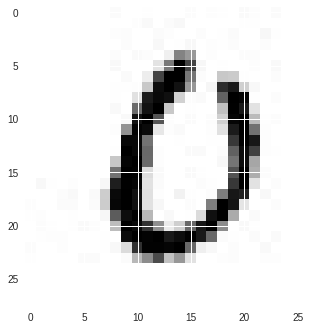

In [13]:
plt.imshow(imageio.imread("./images/0_10007.jpg"))
plt.show()

In [0]:
??get_transforms

In [0]:
pat = r'/([^/]+)_\d+.jpg$'
tfms = get_transforms(do_flip=False, max_lighting=0.1, max_warp=0.3, max_rotate=20, p_lighting=0.5, p_affine=0.7)

In [0]:
data=(ImageList.from_folder("./images")
         .split_by_rand_pct(0.2)
         .label_from_re(pat)
         .transform(tfms)
         .databunch()
         .normalize(imagenet_stats))

In [0]:
#remove the random factor
seed = 42

# python RNG
random.seed(seed)

# pytorch RNGs
import torch
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed)

# numpy RNG
import numpy as np
np.random.seed(seed)

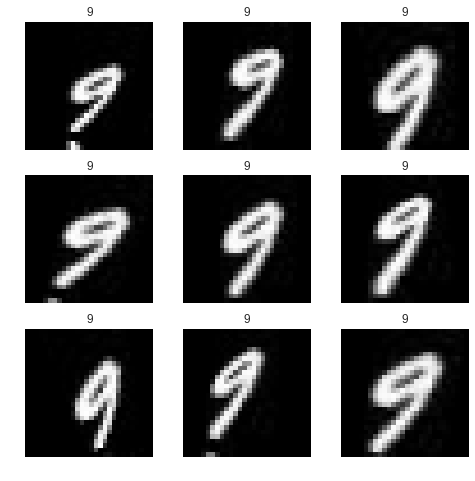

In [65]:
def _plot(i,j,ax):
    x,y = data.train_ds[5]
    x.show(ax, y=y)

plot_multi(_plot, 3, 3, figsize=(8,8))

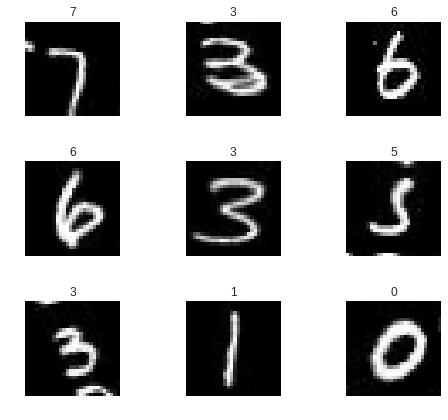

In [66]:
data.show_batch(rows=3, figsize=(7,6))

In [67]:
data.classes

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

In [68]:
learn = cnn_learner(data, models.resnet18, metrics=error_rate, wd=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.torch/models/resnet18-5c106cde.pth
46827520it [00:00, 74832426.91it/s]


In [69]:
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,error_rate,time
0,1.236204,0.926633,0.306548,01:01
1,0.806865,0.542265,0.178929,00:59
2,0.510669,0.287849,0.095119,00:59
3,0.345254,0.179137,0.059286,01:00
4,0.296812,0.133686,0.042738,01:00
5,0.241019,0.119137,0.038571,01:00
6,0.230660,0.101695,0.032143,01:00
7,0.213814,0.093762,0.027857,01:00
8,0.200935,0.096208,0.029524,01:00
9,0.211935,0.094703,0.029286,01:00


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


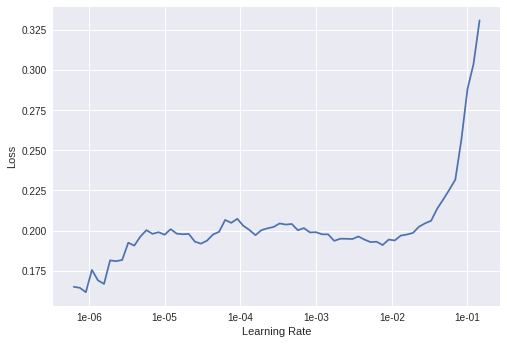

In [70]:
learn.lr_find()
learn.recorder.plot()

In [71]:
learn.unfreeze()
learn.fit_one_cycle(10, max_lr=slice(5e-4,  5e-3))

epoch,train_loss,valid_loss,error_rate,time
0,0.168604,0.066762,0.020357,01:02
1,0.150344,0.081757,0.018929,01:02
2,0.151737,0.082709,0.019762,01:01
3,0.109782,0.047019,0.011786,01:02
4,0.068306,0.042682,0.011905,01:03
5,0.075636,0.036569,0.008452,01:02
6,0.052534,0.033348,0.008333,01:03
7,0.029714,0.022760,0.006310,01:02
8,0.027196,0.021628,0.005714,01:02
9,0.023949,0.022678,0.006310,01:03


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


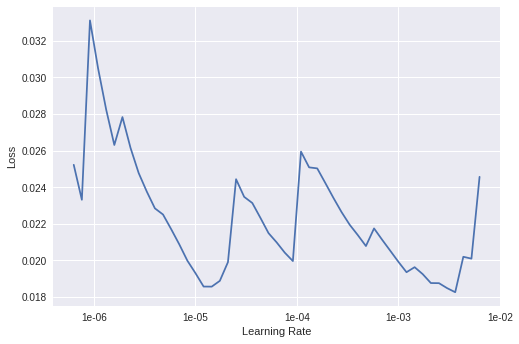

In [79]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.l("stage-1")

In [80]:
learn.fit_one_cycle(15, max_lr=slice(3e-6,  1e-5), pct_start=0.8)

epoch,train_loss,valid_loss,error_rate,time
0,0.020757,0.024019,0.006190,01:01
1,0.017574,0.023590,0.006310,01:03
2,0.014472,0.024073,0.006786,01:03
3,0.015146,0.024410,0.006548,01:03
4,0.017747,0.023494,0.006190,01:03
5,0.022368,0.024086,0.006071,01:03
6,0.015592,0.022462,0.006071,01:03
7,0.014361,0.023823,0.006071,01:03
8,0.020658,0.023707,0.006190,01:03
9,0.014139,0.022975,0.006310,01:03


In [0]:
learn.export("../export.pkl")

In [0]:
interp=ClassificationInterpretation.from_learner(learn)

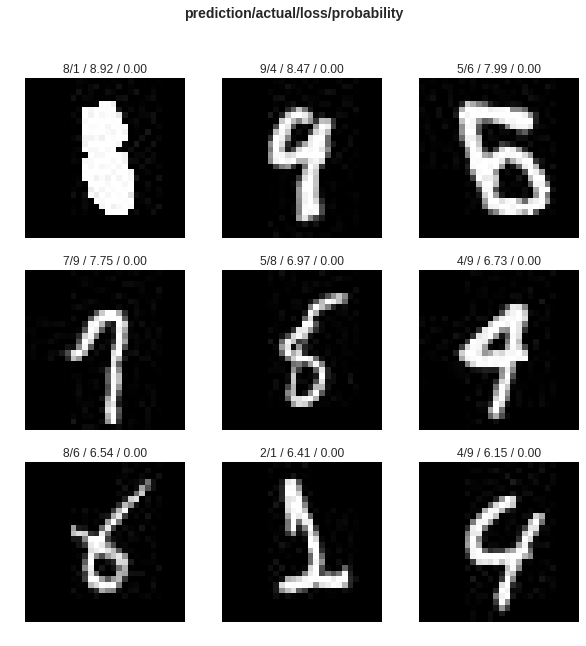

In [82]:
interp.plot_top_losses(9, figsize=(10, 10))

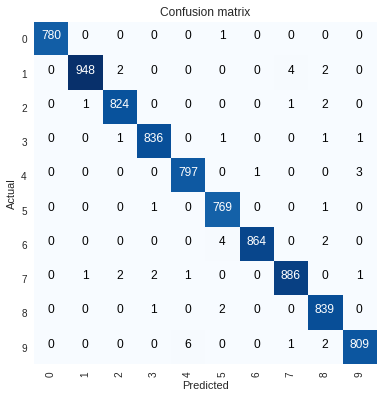

In [83]:
interp.plot_confusion_matrix()

In [84]:
interp.most_confused(min_val=2)

[('9', '4', 6),
 ('1', '7', 4),
 ('6', '5', 4),
 ('4', '9', 3),
 ('1', '2', 2),
 ('1', '8', 2),
 ('2', '8', 2),
 ('6', '8', 2),
 ('7', '2', 2),
 ('7', '3', 2),
 ('8', '5', 2),
 ('9', '8', 2)]

In [0]:
!rm -r test_images/

In [0]:
test_images_df=df_test
!mkdir test_images
for i in range(len(test_images_df)):
  imageio.imwrite(f'./test_images/{"{:06d}".format(i)}.jpg', test_images_df.iloc[i].values.reshape((28,28)).astype('uint8'))

In [176]:
!ls test_images | head -10

000000.jpg
000001.jpg
000002.jpg
000003.jpg
000004.jpg
000005.jpg
000006.jpg
000007.jpg
000008.jpg
000009.jpg


In [0]:
fnames=get_image_files("test_images")

In [0]:
files= pd.DataFrame(data=sorted(fnames), index=range(0,len(fnames)), columns=["path"]) 

In [218]:
files.head(5)

,path
0,test_images/000000.jpg
1,test_images/000001.jpg
2,test_images/000002.jpg
3,test_images/000003.jpg
4,test_images/000004.jpg


In [0]:
test=ImageImageList.from_df(files, ".")

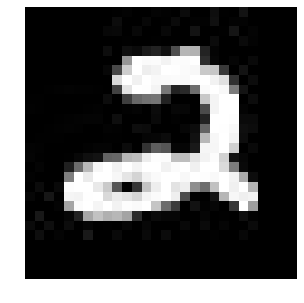

In [225]:
test.get(0).show(figsize=(5,5))

In [0]:
learn = load_learner(".", test=test)

In [0]:
preds,y = learn.get_preds(ds_type=DatasetType.Test)

In [0]:
digits=np.argmax(preds, axis=1)

In [0]:
res_df = pd.DataFrame({'ImageId': range(1, len(df_test)+1), 'Label': digits})
res_df.to_csv('mnist_submission.csv', index=False)

In [230]:
!cat mnist_submission.csv | head -4

ImageId,Label
1,2
2,0
3,9


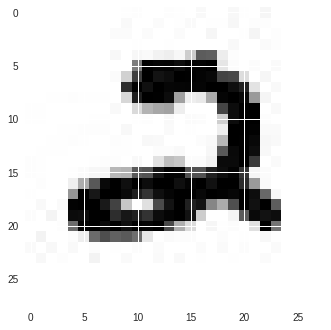

In [194]:
plt.imshow(imageio.imread("test_images/000000.jpg"))

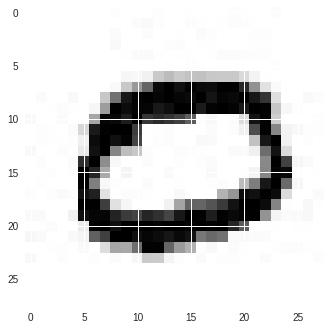

In [195]:
plt.imshow(imageio.imread("test_images/000001.jpg"))

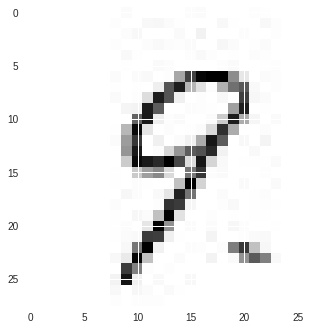

In [196]:
plt.imshow(imageio.imread("test_images/000002.jpg"))